In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:1


In [ ]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [2]:
#Material Properties This link - https://www.mathworks.com/help/pde/ug/nonlinear-heat-transfer-in-a-thin-plate.html#heatTransferThinPlateExample-1
k = 400
rho = 8960
cp = 386
t_z = 0.01
stef_bolt = 5.670373e-8
hc = 1
Ta = 300
emiss = 0.5


In [3]:
label = "Navier_tanh"

x = np.linspace(0,1,100).reshape(-1,1)
y = np.linspace(0,1,100).reshape(-1,1)
t = np.linspace(0,5000,100).reshape(-1,1)

X,Y,T = np.meshgrid(x,y,t)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xyt = np.hstack((X,Y,T))

initial_pts = (T==0).reshape(-1,)

DBC_pts = np.logical_and(Y == 0,T != 0).reshape(-1,)


NBC_pts_1 = (X == 0).reshape(-1,)
NBC_pts_2 = (Y == 0).reshape(-1,)
NBC_pts_3 = (X == 1).reshape(-1,)
NBC_pts_4 = (Y == 1).reshape(-1,)

xyt_initial = xyt[initial_pts,:]
xyt_DBC = xyt[DBC_pts,:]

xyt_NBC_1 = xyt[NBC_pts_1,:]
xyt_NBC_2 = xyt[NBC_pts_2,:]
xyt_NBC_3 = xyt[NBC_pts_3,:]
xyt_NBC_4 = xyt[NBC_pts_4,:]

u_initial = np.zeros((np.shape(xyt_initial)[0],1))
u_DBC = 10*np.ones((np.shape(xyt_DBC)[0],1))

xyt_I_DBC = np.vstack((xyt_initial,xyt_DBC))
xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_2,xyt_NBC_3,xyt_NBC_4))

u_I_DBC = np.vstack((u_initial,u_DBC))

xyt_test_tensor = torch.from_numpy(xyt).float().to(device)

lb_xyt = xyt[0]
ub_xyt = xyt[-1]

In [4]:
def trainingdata(N_D,N_N,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #choose random N_u points for training
    idx = np.random.choice(xyt_I_DBC.shape[0], N_D, replace=False) 
    xyt_D = xyt_I_DBC[idx,:] #choose indices from  set 'idx' (x,t)
    u_D = u_I_DBC[idx].reshape(-1,1)      #choose corresponding u

    idx = np.random.choice(xyt_NBC.shape[0], N_D, replace=False) 
    xyt_N = xyt_NBC[idx,:] #choose indices from  set 'idx' (x,t)


    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xyt_coll = lb_xyt + (ub_xyt - lb_xyt)*samples
    xyt_coll = np.vstack((xyt_coll, xyt_D,xyt_N)) # append training points to collocation points 

    return xyt_coll, xyt_D, u_D, xyt_N

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        
        #self.beta_val = []
        
        self.n = torch.tensor(1.0)
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = (xyt - lbxyt)/(ubxyt - lbxyt)
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            #a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
            a = self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xyt_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xyt_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xyt_N,N_hat):
        
        g = xyt_N.clone()             
        g.requires_grad = True
        u = self.forward(g)
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_N.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du_dx = u_x_y_t[:,[0]]
        du_dy = u_x_y_t[:,[1]]
        
        loss_N1 = self.loss_function(du_dx,N_hat)
        loss_N2 = self.loss_function(du_dy,N_hat)
        
        return loss_N1+loss_N2       
        
    
    def loss_PDE(self, xyt_coll, f_hat):
        
        g = xyt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy_tt = autograd.grad(u_x_y_t,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy_tt[:,[0]]
        d2u_dy2 = u_xx_yy_tt[:,[1]]    
        

        f = rho*cp*t_z*du_dt - k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-Ta**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xyt_D,u_D,xyt_N,N_hat,xyt_coll,f_hat):

        loss_D = self.loss_D(xyt_D,u_D)
        loss_N = self.loss_N(xyt_N,N_hat)
        loss_f = self.loss_PDE(xyt_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        
        loss = self.loss(xyt_D,u_D,xyt_N,N_hat,xyt_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xyt_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        #self.beta_val.append(self.beta.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self,xyt_test_tensor):
        u_pred = self.forward(xyt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [6]:
max_reps = 10

train_loss_full = []
test_loss_full = []
#beta_full = []
elapsed_time= np.zeros((max_reps,1))

for reps in range(max_reps):
    print(reps)
    
    torch.manual_seed(reps*36)
    N_D = 500 #Total number of data points for 'y'
    N_N = 500
    N_f = 10000 #Total number of collocation points 
    
    xyt_coll_np_array, xyt_D_np_array, u_D_np_array,xyt_N_np_array = trainingdata(N_D,N_N,N_f,(reps)*22)
        
    xyt_coll = torch.from_numpy(xyt_coll_np_array).float().to(device)
    xyt_D = torch.from_numpy(xyt_D_np_array).float().to(device)
    u_D = torch.from_numpy(u_D_np_array).float().to(device)
    xyt_N = torch.from_numpy(xyt_N_np_array).float().to(device)
        
    N_hat = torch.zeros(xyt_N.shape[0],1).to(device)    
    f_hat = torch.zeros(xyt_coll.shape[0],1).to(device)

    layers = np.array([3,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 10000, 
                              max_eval = None, 
                              tolerance_grad = -1, 
                              tolerance_change = -1, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



    start_time = time.time()
        
    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    #beta_full.append(PINN.beta_val)


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "label": label}
savemat(label+'.mat', mdic)

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 1122968.0
1 Train Loss 1121611.9
2 Train Loss 1110361.1
3 Train Loss 1084560.9
4 Train Loss 1000752.7
5 Train Loss 3233781.0
6 Train Loss 990101.3
7 Train Loss 954020.3
8 Train Loss 918187.4
9 Train Loss 880274.2
10 Train Loss 842570.75
11 Train Loss 903557.5
12 Train Loss 975340.1
13 T

311 Train Loss 980.80334
312 Train Loss 979.9132
313 Train Loss 979.2357
314 Train Loss 978.8792
315 Train Loss 978.46564
316 Train Loss 978.2256
317 Train Loss 977.82196
318 Train Loss 977.48425
319 Train Loss 977.0516
320 Train Loss 976.63306
321 Train Loss 976.15607
322 Train Loss 975.4573
323 Train Loss 974.1024
324 Train Loss 971.6377
325 Train Loss 970.0775
326 Train Loss 968.8229
327 Train Loss 967.9541
328 Train Loss 968.37146
329 Train Loss 967.3831
330 Train Loss 967.1449
331 Train Loss 966.94586
332 Train Loss 966.80286
333 Train Loss 966.6529
334 Train Loss 966.40424
335 Train Loss 966.20215
336 Train Loss 966.0421
337 Train Loss 965.8933
338 Train Loss 965.7155
339 Train Loss 965.476
340 Train Loss 965.15753
341 Train Loss 964.945
342 Train Loss 964.8008
343 Train Loss 964.6269
344 Train Loss 964.5191
345 Train Loss 964.3508
346 Train Loss 964.0862
347 Train Loss 963.8558
348 Train Loss 963.02423
349 Train Loss 961.89606
350 Train Loss 961.0698
351 Train Loss 966.53613
352

650 Train Loss 915.91895
651 Train Loss 915.89526
652 Train Loss 915.88257
653 Train Loss 915.87164
654 Train Loss 915.863
655 Train Loss 915.8467
656 Train Loss 915.8225
657 Train Loss 915.7843
658 Train Loss 915.7463
659 Train Loss 915.71124
660 Train Loss 915.6852
661 Train Loss 915.6787
662 Train Loss 915.6941
663 Train Loss 915.6547
664 Train Loss 915.63367
665 Train Loss 915.6177
666 Train Loss 915.5899
667 Train Loss 915.5701
668 Train Loss 915.5407
669 Train Loss 915.5231
670 Train Loss 915.5052
671 Train Loss 915.4958
672 Train Loss 915.48267
673 Train Loss 915.47076
674 Train Loss 915.46027
675 Train Loss 915.45
676 Train Loss 915.4395
677 Train Loss 915.42395
678 Train Loss 915.3938
679 Train Loss 915.3582
680 Train Loss 915.33093
681 Train Loss 915.314
682 Train Loss 915.2785
683 Train Loss 915.25214
684 Train Loss 915.21204
685 Train Loss 915.1813
686 Train Loss 915.14404
687 Train Loss 915.1174
688 Train Loss 915.1102
689 Train Loss 915.099
690 Train Loss 915.10254
691 Tr

991 Train Loss 907.2075
992 Train Loss 907.1774
993 Train Loss 907.1599
994 Train Loss 907.1767
995 Train Loss 907.1457
996 Train Loss 907.1169
997 Train Loss 907.06354
998 Train Loss 907.01996
999 Train Loss 906.9643
1000 Train Loss 906.94653
1001 Train Loss 906.85004
1002 Train Loss 907.03796
1003 Train Loss 906.80786
1004 Train Loss 906.7235
1005 Train Loss 906.7162
1006 Train Loss 906.97003
1007 Train Loss 906.63684
1008 Train Loss 906.75275
1009 Train Loss 906.5992
1010 Train Loss 906.5884
1011 Train Loss 906.5448
1012 Train Loss 906.52545
1013 Train Loss 906.5067
1014 Train Loss 906.4886
1015 Train Loss 906.4665
1016 Train Loss 906.4481
1017 Train Loss 906.42145
1018 Train Loss 906.3988
1019 Train Loss 906.3743
1020 Train Loss 906.3622
1021 Train Loss 906.3419
1022 Train Loss 906.3193
1023 Train Loss 906.2932
1024 Train Loss 906.2524
1025 Train Loss 906.2265
1026 Train Loss 906.20306
1027 Train Loss 906.172
1028 Train Loss 906.146
1029 Train Loss 906.13544
1030 Train Loss 906.127

1315 Train Loss 901.5613
1316 Train Loss 901.5585
1317 Train Loss 901.5553
1318 Train Loss 901.55084
1319 Train Loss 901.5474
1320 Train Loss 901.5432
1321 Train Loss 901.53937
1322 Train Loss 901.5387
1323 Train Loss 901.5363
1324 Train Loss 901.53217
1325 Train Loss 901.52704
1326 Train Loss 901.5206
1327 Train Loss 901.51544
1328 Train Loss 901.71643
1329 Train Loss 901.51056
1330 Train Loss 901.50336
1331 Train Loss 901.49066
1332 Train Loss 901.50104
1333 Train Loss 901.47925
1334 Train Loss 901.46747
1335 Train Loss 901.45636
1336 Train Loss 901.4449
1337 Train Loss 901.43207
1338 Train Loss 901.42194
1339 Train Loss 901.42474
1340 Train Loss 901.4166
1341 Train Loss 901.4094
1342 Train Loss 901.4043
1343 Train Loss 901.39856
1344 Train Loss 901.3922
1345 Train Loss 901.3823
1346 Train Loss 901.3723
1347 Train Loss 901.3569
1348 Train Loss 901.34534
1349 Train Loss 901.34155
1350 Train Loss 901.3356
1351 Train Loss 901.33356
1352 Train Loss 901.3301
1353 Train Loss 901.3245
1354 

1642 Train Loss 898.96857
1643 Train Loss 898.9562
1644 Train Loss 898.9532
1645 Train Loss 898.94696
1646 Train Loss 898.94696
1647 Train Loss 898.944
1648 Train Loss 898.9404
1649 Train Loss 898.9363
1650 Train Loss 898.9449
1651 Train Loss 898.9329
1652 Train Loss 898.92804
1653 Train Loss 898.9368
1654 Train Loss 898.9265
1655 Train Loss 898.92303
1656 Train Loss 898.9213
1657 Train Loss 898.9209
1658 Train Loss 898.91956
1659 Train Loss 898.91907
1660 Train Loss 898.918
1661 Train Loss 898.91724
1662 Train Loss 898.9164
1663 Train Loss 898.91473
1664 Train Loss 898.91174
1665 Train Loss 898.90814
1666 Train Loss 898.90356
1667 Train Loss 898.9008
1668 Train Loss 898.8962
1669 Train Loss 898.89233
1670 Train Loss 898.8857
1671 Train Loss 898.87506
1672 Train Loss 898.9219
1673 Train Loss 898.8725
1674 Train Loss 898.868
1675 Train Loss 898.86365
1676 Train Loss 898.8596
1677 Train Loss 898.8536
1678 Train Loss 898.8501
1679 Train Loss 898.8432
1680 Train Loss 898.83777
1681 Train L

1969 Train Loss 897.65247
1970 Train Loss 897.6333
1971 Train Loss 897.628
1972 Train Loss 897.625
1973 Train Loss 897.62024
1974 Train Loss 897.62244
1975 Train Loss 897.61884
1976 Train Loss 897.6166
1977 Train Loss 897.6146
1978 Train Loss 897.61163
1979 Train Loss 897.6077
1980 Train Loss 897.6059
1981 Train Loss 897.60443
1982 Train Loss 897.60394
1983 Train Loss 897.6007
1984 Train Loss 897.5993
1985 Train Loss 897.5977
1986 Train Loss 897.5959
1987 Train Loss 897.5942
1988 Train Loss 897.59283
1989 Train Loss 897.59045
1990 Train Loss 897.58795
1991 Train Loss 897.5859
1992 Train Loss 897.584
1993 Train Loss 897.58264
1994 Train Loss 897.5813
1995 Train Loss 897.58044
1996 Train Loss 897.5799
1997 Train Loss 897.5792
1998 Train Loss 897.5786
1999 Train Loss 897.5777
2000 Train Loss 897.5763
2001 Train Loss 897.5761
2002 Train Loss 897.5741
2003 Train Loss 897.5728
2004 Train Loss 897.57135
2005 Train Loss 897.5696
2006 Train Loss 897.5678
2007 Train Loss 897.56586
2008 Train Los

2297 Train Loss 896.68854
2298 Train Loss 896.6873
2299 Train Loss 896.6855
2300 Train Loss 896.6807
2301 Train Loss 896.6773
2302 Train Loss 896.672
2303 Train Loss 896.6822
2304 Train Loss 896.67017
2305 Train Loss 896.665
2306 Train Loss 896.6617
2307 Train Loss 896.6548
2308 Train Loss 896.64844
2309 Train Loss 896.6434
2310 Train Loss 896.6467
2311 Train Loss 896.6411
2312 Train Loss 896.6367
2313 Train Loss 896.6341
2314 Train Loss 896.6306
2315 Train Loss 896.6271
2316 Train Loss 896.62384
2317 Train Loss 896.62213
2318 Train Loss 896.6143
2319 Train Loss 896.61
2320 Train Loss 896.6104
2321 Train Loss 896.60767
2322 Train Loss 896.6051
2323 Train Loss 896.6008
2324 Train Loss 896.5974
2325 Train Loss 896.5923
2326 Train Loss 896.58636
2327 Train Loss 896.58057
2328 Train Loss 896.5704
2329 Train Loss 896.58057
2330 Train Loss 896.5641
2331 Train Loss 896.55835
2332 Train Loss 896.5497
2333 Train Loss 896.545
2334 Train Loss 896.54047
2335 Train Loss 896.5361
2336 Train Loss 896

2621 Train Loss 895.32513
2622 Train Loss 895.3182
2623 Train Loss 895.3118
2624 Train Loss 895.3065
2625 Train Loss 895.3012
2626 Train Loss 895.2964
2627 Train Loss 895.30084
2628 Train Loss 895.2916
2629 Train Loss 895.28485
2630 Train Loss 895.27783
2631 Train Loss 895.2766
2632 Train Loss 895.26935
2633 Train Loss 895.2648
2634 Train Loss 895.2594
2635 Train Loss 895.25214
2636 Train Loss 895.2491
2637 Train Loss 895.24414
2638 Train Loss 895.23895
2639 Train Loss 895.23395
2640 Train Loss 895.2285
2641 Train Loss 895.2222
2642 Train Loss 895.21606
2643 Train Loss 895.20703
2644 Train Loss 895.2011
2645 Train Loss 895.1951
2646 Train Loss 895.1994
2647 Train Loss 895.19104
2648 Train Loss 895.1865
2649 Train Loss 895.18225
2650 Train Loss 895.1791
2651 Train Loss 895.17554
2652 Train Loss 895.1724
2653 Train Loss 895.1694
2654 Train Loss 895.1668
2655 Train Loss 895.16534
2656 Train Loss 895.1632
2657 Train Loss 895.1613
2658 Train Loss 895.1579
2659 Train Loss 895.1533
2660 Train

2946 Train Loss 893.9614
2947 Train Loss 893.9573
2948 Train Loss 893.96344
2949 Train Loss 893.9557
2950 Train Loss 893.95386
2951 Train Loss 893.9512
2952 Train Loss 893.95013
2953 Train Loss 893.9493
2954 Train Loss 893.9479
2955 Train Loss 893.9463
2956 Train Loss 893.94354
2957 Train Loss 893.9428
2958 Train Loss 893.93805
2959 Train Loss 893.93304
2960 Train Loss 893.9254
2961 Train Loss 893.91724
2962 Train Loss 893.9131
2963 Train Loss 893.9134
2964 Train Loss 893.9108
2965 Train Loss 893.90845
2966 Train Loss 893.9043
2967 Train Loss 893.89667
2968 Train Loss 893.8893
2969 Train Loss 893.8796
2970 Train Loss 893.8718
2971 Train Loss 893.8725
2972 Train Loss 893.8668
2973 Train Loss 893.87915
2974 Train Loss 893.86053
2975 Train Loss 893.85266
2976 Train Loss 893.8452
2977 Train Loss 893.84033
2978 Train Loss 893.83356
2979 Train Loss 893.82587
2980 Train Loss 893.8173
2981 Train Loss 893.8071
2982 Train Loss 893.79944
2983 Train Loss 893.7942
2984 Train Loss 893.7885
2985 Trai

3270 Train Loss 892.1927
3271 Train Loss 892.2381
3272 Train Loss 892.19006
3273 Train Loss 892.186
3274 Train Loss 892.18225
3275 Train Loss 892.18207
3276 Train Loss 892.18
3277 Train Loss 892.1775
3278 Train Loss 892.1756
3279 Train Loss 892.17316
3280 Train Loss 892.1696
3281 Train Loss 892.1652
3282 Train Loss 892.15656
3283 Train Loss 892.16034
3284 Train Loss 892.15344
3285 Train Loss 892.14453
3286 Train Loss 892.1588
3287 Train Loss 892.1407
3288 Train Loss 892.136
3289 Train Loss 892.13165
3290 Train Loss 892.1291
3291 Train Loss 892.1262
3292 Train Loss 892.12225
3293 Train Loss 892.11945
3294 Train Loss 892.116
3295 Train Loss 892.11975
3296 Train Loss 892.1147
3297 Train Loss 892.1128
3298 Train Loss 892.1113
3299 Train Loss 892.11017
3300 Train Loss 892.108
3301 Train Loss 892.1035
3302 Train Loss 892.0988
3303 Train Loss 892.0943
3304 Train Loss 892.09216
3305 Train Loss 892.087
3306 Train Loss 892.084
3307 Train Loss 892.08545
3308 Train Loss 892.0802
3309 Train Loss 89

3594 Train Loss 891.01636
3595 Train Loss 891.01605
3596 Train Loss 891.0146
3597 Train Loss 891.01385
3598 Train Loss 891.0132
3599 Train Loss 891.012
3600 Train Loss 891.0114
3601 Train Loss 891.0105
3602 Train Loss 891.0097
3603 Train Loss 891.009
3604 Train Loss 891.00757
3605 Train Loss 891.0058
3606 Train Loss 891.0055
3607 Train Loss 891.0051
3608 Train Loss 891.00415
3609 Train Loss 891.00354
3610 Train Loss 891.0023
3611 Train Loss 891.0021
3612 Train Loss 890.99976
3613 Train Loss 890.9988
3614 Train Loss 890.9984
3615 Train Loss 890.9966
3616 Train Loss 890.9957
3617 Train Loss 890.99493
3618 Train Loss 890.9927
3619 Train Loss 890.9917
3620 Train Loss 890.99
3621 Train Loss 890.9956
3622 Train Loss 890.9885
3623 Train Loss 890.9861
3624 Train Loss 890.98376
3625 Train Loss 890.9819
3626 Train Loss 890.97925
3627 Train Loss 890.97906
3628 Train Loss 890.9773
3629 Train Loss 890.97516
3630 Train Loss 891.0037
3631 Train Loss 890.9731
3632 Train Loss 890.9718
3633 Train Loss 8

3922 Train Loss 890.3855
3923 Train Loss 890.38434
3924 Train Loss 890.383
3925 Train Loss 890.3814
3926 Train Loss 890.3793
3927 Train Loss 890.37646
3928 Train Loss 890.37524
3929 Train Loss 890.3732
3930 Train Loss 890.37177
3931 Train Loss 890.3714
3932 Train Loss 890.3697
3933 Train Loss 890.36847
3934 Train Loss 890.3664
3935 Train Loss 890.3658
3936 Train Loss 890.36334
3937 Train Loss 890.362
3938 Train Loss 890.35767
3939 Train Loss 890.3541
3940 Train Loss 890.3558
3941 Train Loss 890.3527
3942 Train Loss 890.3547
3943 Train Loss 890.3505
3944 Train Loss 890.3493
3945 Train Loss 890.3484
3946 Train Loss 890.34766
3947 Train Loss 890.34674
3948 Train Loss 890.34515
3949 Train Loss 890.34357
3950 Train Loss 890.34186
3951 Train Loss 890.3396
3952 Train Loss 890.34436
3953 Train Loss 890.33875
3954 Train Loss 890.33636
3955 Train Loss 890.33276
3956 Train Loss 890.3301
3957 Train Loss 890.3277
3958 Train Loss 890.32587
3959 Train Loss 890.32404
3960 Train Loss 890.3229
3961 Trai

KeyboardInterrupt: 

In [8]:
u_pred = PINN.test(xyt_test_tensor)
u_pred_3d = u_pred.reshape(100,100,100)

In [12]:
u_pred_3d.shape

(100, 100, 100)

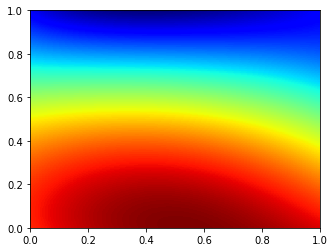

In [24]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

#img3 = ax.imshow(u_pred_3d[75,:,:],vmin = 0,vmax = 10,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
img3 = ax.imshow(np.transpose(u_pred_3d[99,:,:]),cmap = cmap,extent=[0,1,0,1],aspect = 0.75)


In [ ]:
a = 0
for i in range(10):
    a = a + test_loss_full[i][-1]
print(a/10)

In [ ]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)